In [38]:
import pandas as pd
import numpy as np

In [39]:
import matplotlib.pyplot as plt


def draw_loss_acc(train_loss, val_loss, train_acc, val_acc):
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.legend()
    plt.show()

    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.legend()
    plt.show()

In [40]:
dataset = pd.read_csv("creditcard.csv")

In [41]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: >

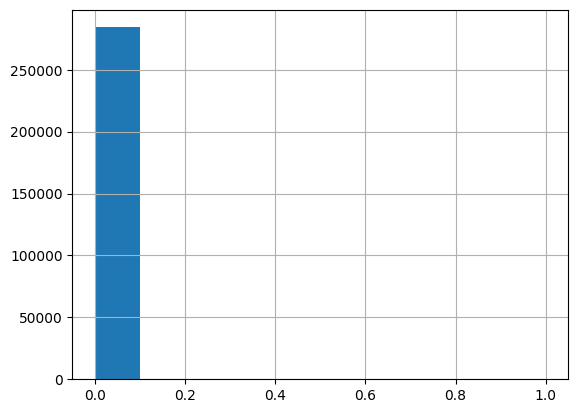

In [42]:
dataset['Class'].hist()

In [43]:
dataset['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [44]:
from torch import nn
import torch

class FraudNN(nn.Module):
    def __init__(self):
        super(FraudNN, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=30, out_channels=32, kernel_size=2, padding=1
        )
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64, 64)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        input_x = x.unsqueeze(-1)
        x = torch.relu(self.bn1(self.conv1(input_x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch

dataset_X = dataset.drop(columns=["Class"])
dataset_y = dataset["Class"]

X_temp, X_test, y_temp, y_test = train_test_split(
    dataset_X, dataset_y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()
X_val_tensor = torch.tensor(X_val.values).float()
y_val_tensor = torch.tensor(y_val.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train DataLoader has {len(train_dataloader.dataset)} samples.")
print(f"Validation DataLoader has {len(val_dataloader.dataset)} samples.")
print(f"Test DataLoader has {len(test_dataloader.dataset)} samples.")

Train DataLoader has 170883 samples.
Validation DataLoader has 56962 samples.
Test DataLoader has 56962 samples.


In [10]:
import torch.optim as optim


class Optimizer:
    def __init__(self, model_parameters, lr=0.001, optimizer_type="adam"):
        self.optimizer_type = optimizer_type
        self.lr = lr
        self.optimizer = self.create_optimizer(model_parameters)

    def create_optimizer(self, model_parameters):
        if self.optimizer_type == "sgd":
            return optim.SGD(model_parameters, lr=self.lr)
        elif self.optimizer_type == "adam":
            return optim.Adam(model_parameters, lr=self.lr)
        elif self.optimizer_type == "rmsprop":
            return optim.RMSprop(model_parameters, lr=self.lr)
        else:
            raise ValueError("Unknown optimizer type")

    def step(self):
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FraudNN().to(device)
model_parameters = model.parameters()
optimizer = Optimizer(model_parameters, lr=0.0001, optimizer_type="adam")
criterion = nn.BCEWithLogitsLoss()

In [11]:
from tqdm import tqdm

def binary_accuracy(preds, y):
    sigmoid = nn.Sigmoid()
    rounded_preds = sigmoid(preds).round()
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for idx, (x, labels) in tqdm(enumerate(iterator), total=len(iterator)):
        optimizer.zero_grad()
        predictions = model(x.to(device))
        predictions = predictions.squeeze(1)
        loss = criterion(predictions, labels.to(device))
        acc = binary_accuracy(predictions, labels.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for x, labels in iterator:
            predictions = model(x.to(device))
            predictions = predictions.squeeze(1)
            loss = criterion(predictions, labels.to(device))
            acc = binary_accuracy(predictions, labels.to(device))
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
import time as time 
start_time = time.time()
loss_list = []
acc_list = []
val_loss_list = []
val_acc_list = []
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)
    loss_list.append(train_loss)
    acc_list.append(train_acc)
    val_loss_list.append(valid_loss)
    val_acc_list.append(valid_acc)
    print(
        f"Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:3f}, Val. Acc: {valid_acc*100:.2f}%"
    )

end_time = time.time()
print(f"Total training time: {end_time - start_time}s")


  0%|          | 0/2671 [00:00<?, ?it/s]

100%|██████████| 2671/2671 [00:08<00:00, 326.21it/s]


Epoch: 01, Train Loss: 0.045, Train Acc: 99.08%, Val. Loss: 0.010238, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:07<00:00, 354.97it/s]


Epoch: 02, Train Loss: 0.016, Train Acc: 99.82%, Val. Loss: 0.010177, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:06<00:00, 385.13it/s]


Epoch: 03, Train Loss: 0.015, Train Acc: 99.82%, Val. Loss: 0.010439, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:06<00:00, 388.79it/s]


Epoch: 04, Train Loss: 0.015, Train Acc: 99.82%, Val. Loss: 0.010367, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:07<00:00, 365.39it/s]


Epoch: 05, Train Loss: 0.015, Train Acc: 99.82%, Val. Loss: 0.010443, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:07<00:00, 379.16it/s]


Epoch: 06, Train Loss: 0.015, Train Acc: 99.82%, Val. Loss: 0.010399, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:06<00:00, 411.07it/s]


Epoch: 07, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010304, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:06<00:00, 415.92it/s]


Epoch: 08, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010418, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:06<00:00, 396.74it/s]


Epoch: 09, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010684, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:06<00:00, 392.69it/s]


Epoch: 10, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010298, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:07<00:00, 377.57it/s]


Epoch: 11, Train Loss: 0.015, Train Acc: 99.82%, Val. Loss: 0.010357, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:07<00:00, 336.09it/s]


Epoch: 12, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010197, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:08<00:00, 306.17it/s]


Epoch: 13, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010253, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:08<00:00, 316.84it/s]


Epoch: 14, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010304, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:07<00:00, 358.11it/s]


Epoch: 15, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010404, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:10<00:00, 258.81it/s]


Epoch: 16, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010630, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:06<00:00, 398.59it/s]


Epoch: 17, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010312, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:06<00:00, 402.50it/s]


Epoch: 18, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.011481, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:07<00:00, 374.10it/s]


Epoch: 19, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.011379, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:07<00:00, 334.41it/s]


Epoch: 20, Train Loss: 0.014, Train Acc: 99.82%, Val. Loss: 0.010999, Val. Acc: 99.86%
Total training time: 165.3276424407959s


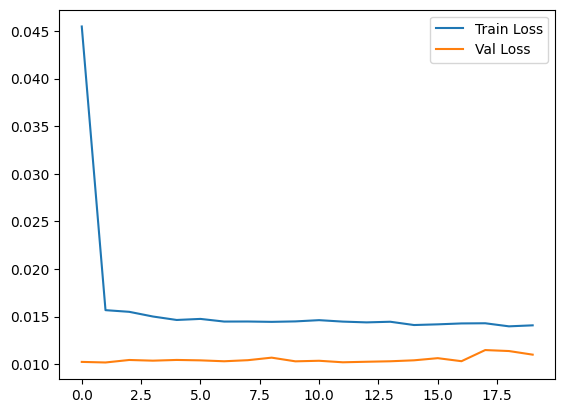

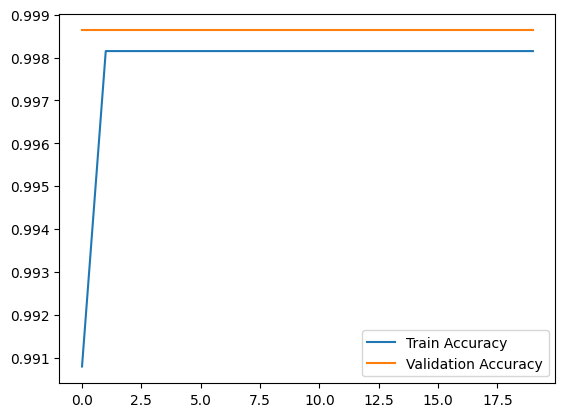

In [13]:
draw_loss_acc(loss_list,val_loss_list,acc_list,val_acc_list)

(170883, 1)
(170883,)
[[170567      0]
 [   316      0]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    170567
         1.0       0.00      0.00      0.00       316

    accuracy                           1.00    170883
   macro avg       0.50      0.50      0.50    170883
weighted avg       1.00      1.00      1.00    170883



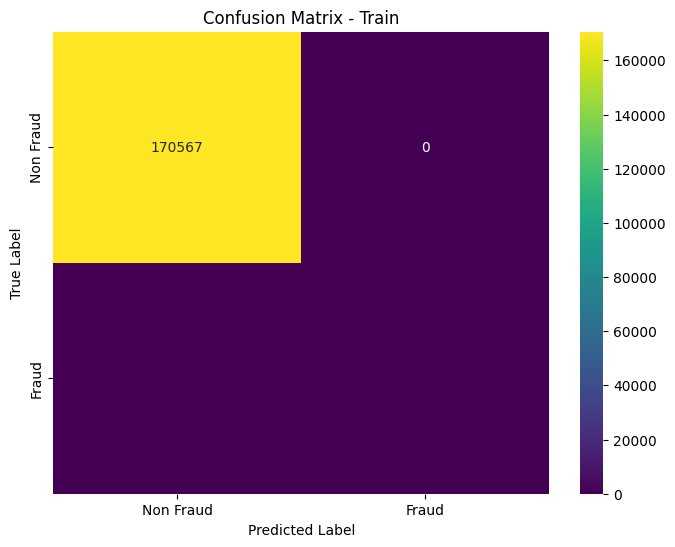

(56962, 1)
(56962,)
[[56884     0]
 [   78     0]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56884
         1.0       0.00      0.00      0.00        78

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



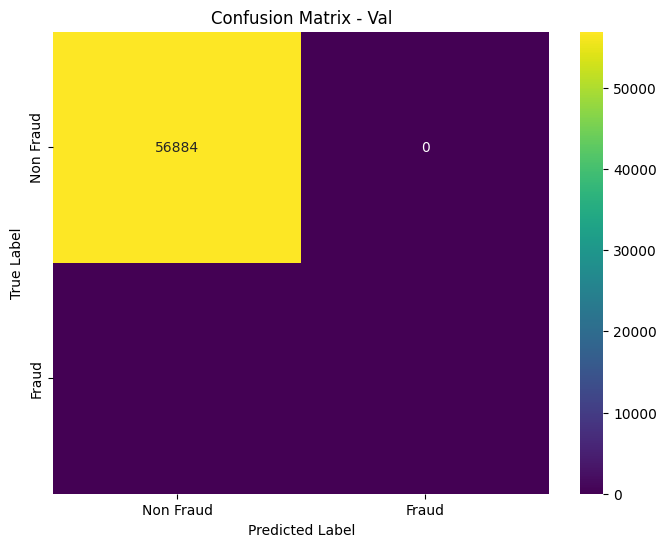

(56962, 1)
(56962,)
[[56864     0]
 [   98     0]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



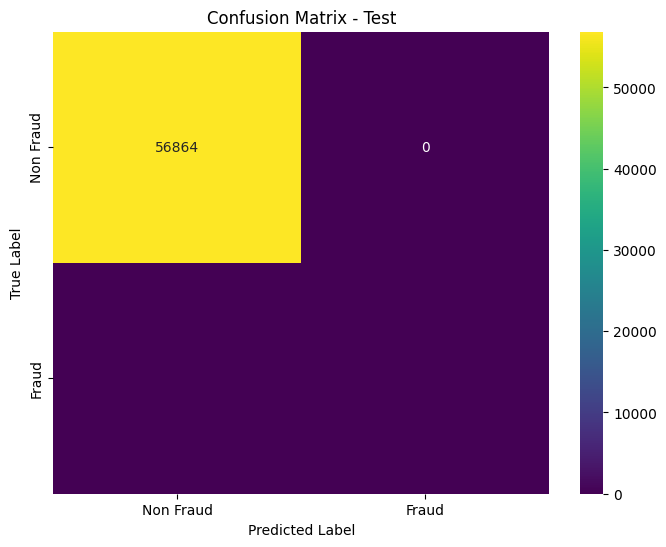

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def report_and_plot_heatmap(model, dataloaders, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    for phase in ["train", "val", "test"]:
        true_labels = []
        predictions = []
        with torch.no_grad():
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = torch.sigmoid(outputs).round()
                true_labels.extend(labels.cpu().numpy())
                predictions.extend(preds.cpu().numpy())
        
        print(np.array(predictions).shape)
        print(np.array(true_labels).shape)
        cm = confusion_matrix(true_labels, np.array(predictions)[:,0])
        cr = classification_report(true_labels,predictions,zero_division=0)
        print(cm)
        print(cr)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="viridis",
            xticklabels=class_names,
            yticklabels=class_names,
        )
        plt.title(f"Confusion Matrix - {phase.title()}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()


dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader,
    "test": test_dataloader,
}
class_names = ["Non Fraud", "Fraud"]
report_and_plot_heatmap(model, dataloaders, class_names)

In [46]:
# The provided code is an implementation of the ADASYN algorithm for generating synthetic data to balance classes in an imbalanced dataset.
# The goal is to refactor the code without changing its functionality.

import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import check_array, check_random_state
from collections import Counter


class ADASYN:
    def __init__(self, ratio=0.5, imb_threshold=0.5, k=5, random_state=None):
        self.ratio = ratio
        self.imb_threshold = imb_threshold
        self.k = k
        self.random_state = random_state

    def _fit(self, X, y):
        self.X = check_array(X)
        self.y = np.array(y).astype(np.int64)
        self.random_state_ = check_random_state(self.random_state)
        self.unique_classes_ = set(self.y)
        self.class_stats_ = Counter(self.y)
        self.majority_class_ = self.class_stats_.most_common(1)[0][0]

    def _generate_samples(self, class_samples, knn_indices, knn_labels, target_class):
        synthetic_data = []
        synthetic_labels = []
        for idx, sample_idx in enumerate(class_samples):
            minority_neighbors = [
                knn
                for knn, label in zip(knn_indices[idx], knn_labels[idx])
                if label == target_class
            ]
            if not minority_neighbors:
                continue

            n_synthetic = int(self.sample_counts_[idx])
            for _ in range(n_synthetic):
                neighbor_idx = self.random_state_.choice(minority_neighbors)
                lambda_val = self.random_state_.random_sample()
                synthetic_sample = (
                    self.X[sample_idx]
                    + (self.X[neighbor_idx] - self.X[sample_idx]) * lambda_val
                )
                synthetic_data.append(synthetic_sample)
                synthetic_labels.append(self.y[sample_idx])

        return np.array(synthetic_data), np.array(synthetic_labels)

    def _oversample(self):
        synthetic_X, synthetic_y = np.empty((0, self.X.shape[1])), np.empty((0,))
        for target_class in self.unique_classes_:
            class_ratio = (
                float(self.class_stats_[target_class])
                / self.class_stats_[self.majority_class_]
            )
            if class_ratio > self.imb_threshold:
                continue
            n_synthetic = (
                self.class_stats_[self.majority_class_]
                - self.class_stats_[target_class]
            ) * self.ratio
            neighbors = NearestNeighbors(n_neighbors=self.k + 1).fit(self.X)
            target_samples = np.where(self.y == target_class)[0]
            knn_indices = neighbors.kneighbors(
                self.X[target_samples], return_distance=False
            )
            knn_labels = self.y[knn_indices].reshape(knn_indices.shape)
            difficulty = np.array(
                [
                    Counter(labels)[self.majority_class_] / float(self.k)
                    for labels in knn_labels
                ]
            )
            self.sample_counts_ = (
                np.rint((difficulty / difficulty.sum()) * n_synthetic)
                if difficulty.sum()
                else difficulty
            )
            data, labels = self._generate_samples(
                target_samples, knn_indices, knn_labels, target_class
            )
            synthetic_X = np.vstack([synthetic_X, data])
            synthetic_y = np.concatenate([synthetic_y, labels])

        return synthetic_X, synthetic_y

    def fit_transform(self, X, y):
        self._fit(X, y)
        synthetic_X, synthetic_y = self._oversample()
        return np.concatenate((self.X, synthetic_X)), np.concatenate(
            (self.y, synthetic_y)
        )


In [66]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
# becuase for some instances the deficallity is so high,
# there is no neighbor of the same minority class so that the synthetic data cannot be generated
# so we need to increase the number of neighbors
ada_sn = ADASYN(k=5000, imb_threshold=0.6, ratio=1)

dataset_X_us, dataset_y_us = ada_sn.fit_transform(X_train, y_train)

0    227451
1       394
Name: Class, dtype: int64
1.0    170583
0.0    170567
dtype: int64


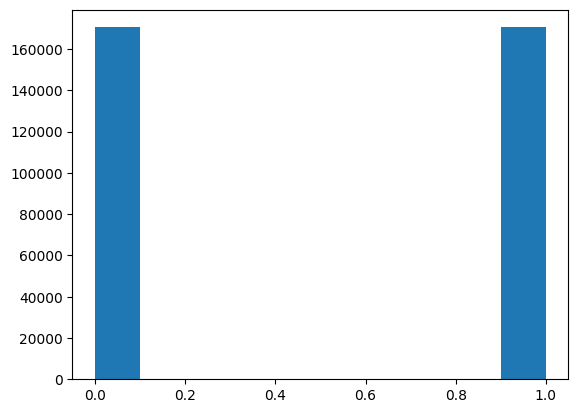

In [67]:
plt.hist(dataset_y_us)
print(pd.Series(y_temp).value_counts())
print(pd.Series(dataset_y_us).value_counts())

In [68]:
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)
print(type(X_train), X_train.shape)
# scale the traind and fit the test and the val:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
# print the shape:
print(X_train.shape, X_val.shape, X_test.shape)
X_train_tensor_us = torch.tensor(X_train).float()
y_train_tensor_us = torch.tensor(np.array(y_train)).float()
X_val_tensor_us = torch.tensor(X_val).float()
y_val_tensor_us = torch.tensor(np.array(y_val)).float()
X_test_tensor_us = torch.tensor(X_test).float()
y_test_tensor_us = torch.tensor(np.array(y_test)).float()

train_dataset_us = TensorDataset(X_train_tensor_us, y_train_tensor_us)
val_dataset_us = TensorDataset(X_val_tensor_us, y_val_tensor_us)
test_dataset_us = TensorDataset(X_test_tensor_us, y_test_tensor_us)

train_dataloader_us = DataLoader(train_dataset_us, batch_size=64, shuffle=True)
val_dataloader_us = DataLoader(val_dataset_us, batch_size=64, shuffle=False)
test_dataloader_us = DataLoader(test_dataset_us, batch_size=64, shuffle=False)

print(f"Train DataLoader has {len(train_dataloader_us.dataset)} samples.")
print(f"Validation DataLoader has {len(val_dataloader_us.dataset)} samples.")
print(f"Test DataLoader has {len(test_dataloader_us.dataset)} samples.")

<class 'pandas.core.frame.DataFrame'> (170883, 30)
(170883, 30) (56962, 30) (56962, 30)
Train DataLoader has 170883 samples.
Validation DataLoader has 56962 samples.
Test DataLoader has 56962 samples.


/home/syntheticdemon/.local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [69]:
# draw the histogram of the train dataset:
import matplotlib.pyplot as plt
# plt.hist(y_train)

In [70]:
import time as time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_us = FraudNN().to(device)
model_parameters_us = model_us.parameters()
optimizer = Optimizer(model_parameters_us, lr=0.0001, optimizer_type="adam")
criterion = nn.BCEWithLogitsLoss()

start_time = time.time()
loss_list = []
acc_list = []
val_loss_list = []
val_acc_list = []
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_us, train_dataloader_us, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_us, val_dataloader_us, criterion)
    loss_list.append(train_loss)
    acc_list.append(train_acc)
    val_loss_list.append(valid_loss)
    val_acc_list.append(valid_acc)
    print(
        f"Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:3f}, Val. Acc: {valid_acc*100:.2f}%"
    )

end_time = time.time()
print(f"Total training time: {end_time - start_time}s")

  0%|          | 0/2671 [00:00<?, ?it/s]

100%|██████████| 2671/2671 [00:08<00:00, 306.84it/s]


Epoch: 01, Train Loss: 0.044, Train Acc: 99.63%, Val. Loss: 0.004411, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:08<00:00, 331.38it/s]


Epoch: 02, Train Loss: 0.007, Train Acc: 99.82%, Val. Loss: 0.003209, Val. Acc: 99.86%


100%|██████████| 2671/2671 [00:09<00:00, 294.85it/s]


Epoch: 03, Train Loss: 0.006, Train Acc: 99.83%, Val. Loss: 0.003153, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:08<00:00, 299.59it/s]


Epoch: 04, Train Loss: 0.005, Train Acc: 99.87%, Val. Loss: 0.003111, Val. Acc: 99.96%


100%|██████████| 2671/2671 [00:08<00:00, 312.52it/s]


Epoch: 05, Train Loss: 0.004, Train Acc: 99.90%, Val. Loss: 0.002799, Val. Acc: 99.96%


100%|██████████| 2671/2671 [00:10<00:00, 249.97it/s]


Epoch: 06, Train Loss: 0.004, Train Acc: 99.92%, Val. Loss: 0.002835, Val. Acc: 99.96%


100%|██████████| 2671/2671 [00:08<00:00, 318.82it/s]


Epoch: 07, Train Loss: 0.004, Train Acc: 99.92%, Val. Loss: 0.002753, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:08<00:00, 331.84it/s]


Epoch: 08, Train Loss: 0.004, Train Acc: 99.93%, Val. Loss: 0.002717, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:08<00:00, 310.78it/s]


Epoch: 09, Train Loss: 0.004, Train Acc: 99.93%, Val. Loss: 0.002811, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:08<00:00, 329.72it/s]


Epoch: 10, Train Loss: 0.003, Train Acc: 99.93%, Val. Loss: 0.002724, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:08<00:00, 318.15it/s]


Epoch: 11, Train Loss: 0.003, Train Acc: 99.93%, Val. Loss: 0.002804, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:08<00:00, 328.50it/s]


Epoch: 12, Train Loss: 0.003, Train Acc: 99.94%, Val. Loss: 0.002724, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:08<00:00, 316.51it/s]


Epoch: 13, Train Loss: 0.003, Train Acc: 99.93%, Val. Loss: 0.002697, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:08<00:00, 328.33it/s]


Epoch: 14, Train Loss: 0.003, Train Acc: 99.93%, Val. Loss: 0.002717, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:08<00:00, 329.90it/s]


Epoch: 15, Train Loss: 0.003, Train Acc: 99.94%, Val. Loss: 0.002813, Val. Acc: 99.96%


100%|██████████| 2671/2671 [00:08<00:00, 331.20it/s]


Epoch: 16, Train Loss: 0.003, Train Acc: 99.94%, Val. Loss: 0.002733, Val. Acc: 99.96%


100%|██████████| 2671/2671 [00:07<00:00, 365.58it/s]


Epoch: 17, Train Loss: 0.003, Train Acc: 99.93%, Val. Loss: 0.002799, Val. Acc: 99.96%


100%|██████████| 2671/2671 [00:10<00:00, 246.64it/s]


Epoch: 18, Train Loss: 0.003, Train Acc: 99.94%, Val. Loss: 0.002861, Val. Acc: 99.95%


100%|██████████| 2671/2671 [00:07<00:00, 347.43it/s]


Epoch: 19, Train Loss: 0.003, Train Acc: 99.94%, Val. Loss: 0.002826, Val. Acc: 99.96%


100%|██████████| 2671/2671 [00:08<00:00, 324.45it/s]


Epoch: 20, Train Loss: 0.003, Train Acc: 99.94%, Val. Loss: 0.002898, Val. Acc: 99.96%
Total training time: 188.2394015789032s


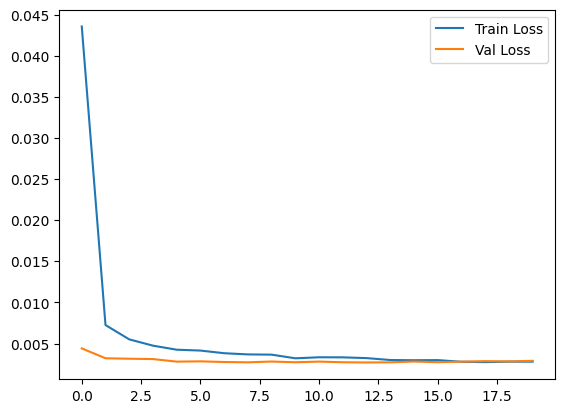

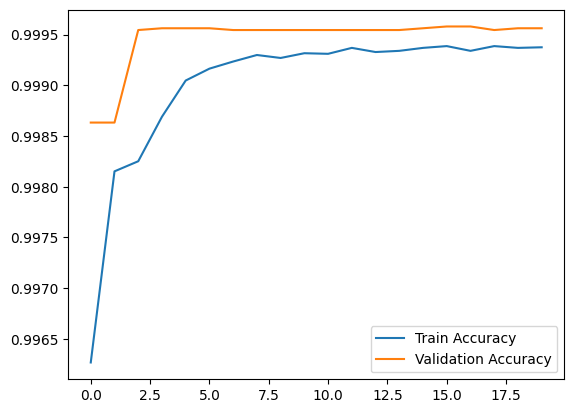

(170883, 1)
(170883,)
[[170523     44]
 [    53    263]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    170567
         1.0       0.86      0.83      0.84       316

    accuracy                           1.00    170883
   macro avg       0.93      0.92      0.92    170883
weighted avg       1.00      1.00      1.00    170883



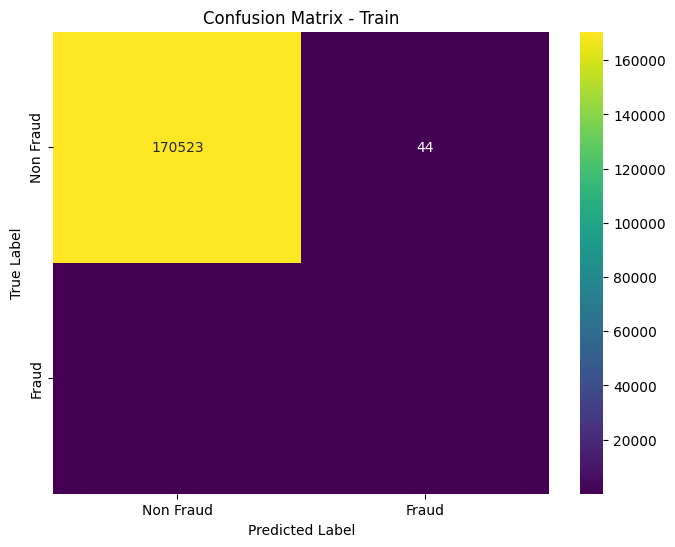

(56962, 1)
(56962,)
[[56873    11]
 [   14    64]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56884
         1.0       0.85      0.82      0.84        78

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



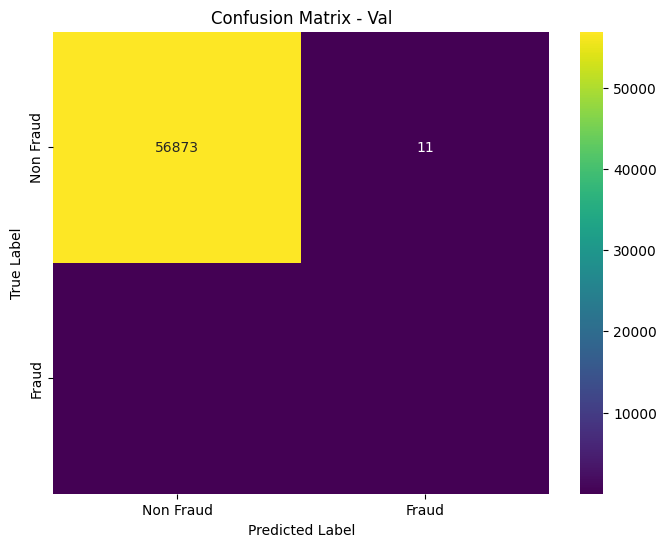

(56962, 1)
(56962,)
[[56864     0]
 [   98     0]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



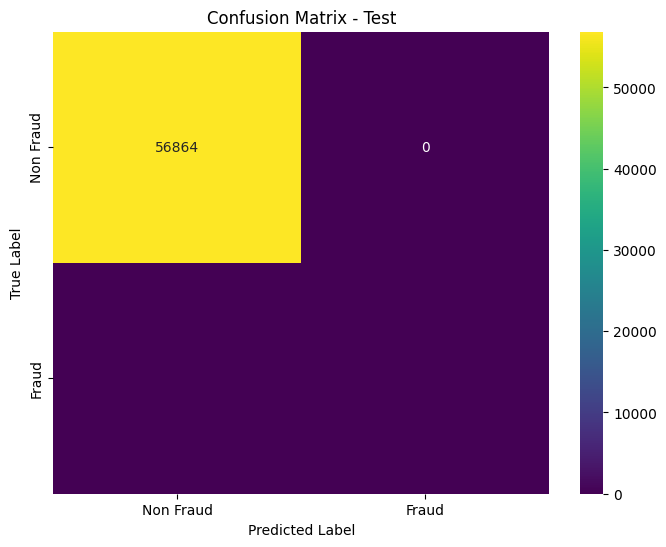

In [71]:
draw_loss_acc(loss_list,val_loss_list,acc_list,val_acc_list)
dataloaders_us = {
    "train": train_dataloader_us,
    "val": val_dataloader_us,
    "test": test_dataloader_us,
}
report_and_plot_heatmap(model_us, dataloaders_us, class_names)
# print(min(loss_list))
# print(max(acc_list))
# print(min(val_loss_list))
# print(max(val_acc_list))
# print(val_acc_list.index(max(val_acc_list)))